# Differential Equations in Julia

Here are some examples to get you started with solving (ordinary) differential equations (ODEs) in Julia using the astoundingly versatile **DifferentialEquations.jl** Library. For a more comprehensive intro, see the [documentation](https://docs.sciml.ai/) and especially the [tutorials](https://github.com/SciML/SciMLTutorials.jl) which go way beyond what we will cover to include a large variety of types of differential equations and specialized solvers and capabilities.

In [1]:
#Set up the Julia environment to use standard packages using Project and Manifest in file directory
import Pkg; 
Pkg.activate(".")
Pkg.instantiate()
Pkg.status() #Check what packages are available

  Activating project at `~/Library/CloudStorage/Dropbox/Computational Methods/Models/Julia`


Status `~/Library/CloudStorage/Dropbox/Computational Methods/Models/Julia/Project.toml`
  [28f2ccd6] ApproxFun v0.13.16
  [a134a8b2] BlackBoxOptim v0.6.2
  [e2554f3b] Clp v1.0.2
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.86
  [442a2c76] FastGaussQuadrature v0.5.0
  [f6369f11] ForwardDiff v0.10.35
  [a98d9a8b] Interpolations v0.14.7
  [b6b21f68] Ipopt v1.2.0
  [4076af6c] JuMP v1.9.0
  [0fc2ff8b] LeastSquaresOptim v0.8.4
  [d41bc354] NLSolversBase v7.8.3
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.7.4
  [d96e819e] Parameters v0.12.3
  [91a5bcdd] Plots v1.38.8
  [8a4e6c94] QuasiMonteCarlo v0.2.19
  [f2b01f46] Roots v2.0.10
  [276daf66] SpecialFunctions v2.2.0
  [e88e6eb3] Zygote v0.6.59
  [37e2e46d] LinearAlgebra
  [10745b16] Statistics


In [2]:
using DifferentialEquations #Load library

In [3]:
using Plots
gr(fmt=:png); # setting for easier graph display in jupyter notebooks

Let's solve our first differential equation: to begin with, something where we know the answer: a univariate linear ODE with constant coefficients:
$$\frac{du}{dt}=f(u,t)=a\cdot u$$
With the growth rate alone, we have a family of solutions. To pin down a solution uniquely, we need one more condition, the initial value:
$$u(0)=u_0$$
Together, these two define an initial value problem, and can be solved over for the value of u at any time. For a numerical solution solved iteratively, we must declare a time span $t\in [0,T]$

In [4]:
#Declare the growth rate as a function of current value u, parameters p, and time t
f(u,p,t) = 0.05*u #Grow at a rate of 5% per unit of time
#Declare the initial condition
u0 = 1.0
#Declare the time span
T=4.0 
tspan=(0,T);

In [5]:
#Declare the problem as an ODE
prob=ODEProblem(f,u0,tspan) #You could add options here, but start with the default method

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 4.0)
u0: 1.0

In [6]:
#Now solve it! This will use the default solver, which is a higher order Runge-Kutta method, with specialized interpolation between grid points
sol=solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 4-element Vector{Float64}:
 0.0
 0.1820928170308875
 2.003020987339762
 4.0
u: 4-element Vector{Float64}:
 1.0
 1.0091462141683158
 1.1053378660660116
 1.2214027582015603

That's it: it solved at 4 grid points t between the start and the end, which are displayed as arrays. But note that the solution object is an interpolation, so you you can also call it at points in between.

In [7]:
@show sol[2] #Display at second grid point
@show sol(3.1) #Display at a particular time

sol[2] = 1.0091462141683158
sol(3.1) = 1.1676579612935145


1.1676579612935145

Because this is an equation where we know the true solution, we can compare and see how accurate the solver was.
Recall that for a linear ODE, the true solution is
$$u(t)=u_0\cdot e^{at}$$

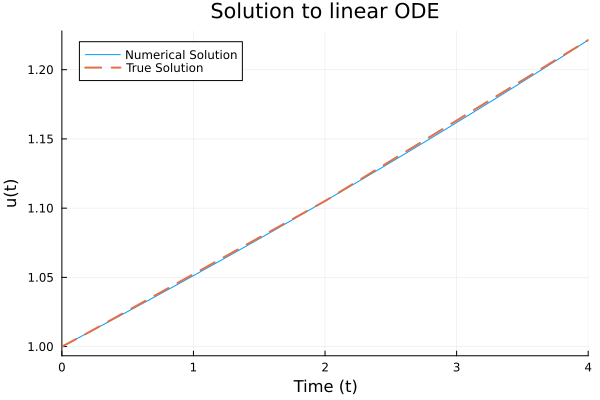

In [8]:
#Plot the numerical and true solution over the domain
plot(sol,title="Solution to linear ODE",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical Solution")
plot!(sol.t, t->u0*exp(0.05t),lw=2,ls=:dash,label="True Solution")

That looks pretty good, but this was an easy problem. Iterative solvers using an explicit time step can often do very poorly if the growth rate between time steps is large (in multivariate cases, when the Jacobian of the function f is ill-conditioned), requiring very tiny time steps to get good accuracy, which makes the procedure slow and unstable. Such problems are often called **stiff** ODEs, and one tends to get a better solution using an implicit method. Let's illustrate this in the linear case and see how much difference the method makes.

In [9]:
#New problem with huge growth rate
f2(u,p,t) = 100*u #Grow 100 times per period
tspan2 = (0.0,1.0) #We will see fast growth even in a short period
stiffprob = ODEProblem(f2,u0,tspan2) #Set up problem same as before except for growth rate and span

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 1.0

In [10]:
sol2 = solve(stiffprob) #Solve using default method

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 92-element Vector{Float64}:
 0.0
 0.01
 0.015886584103585517
 0.023990806386257797
 0.03187441006669821
 0.04050745168712564
 0.049431556160640114
 0.05875355888778445
 0.06836760235700838
 0.07825396626128998
 0.088368212706008
 0.0986806102405564
 0.10916194858916306
 ⋮
 0.8819461637012606
 0.893389202386942
 0.9048322428914457
 0.9162752836990865
 0.9277183255677072
 0.9391613684973077
 0.9506044124878882
 0.9620474575394489
 0.9734905028941467
 0.9849335493098248
 0.996376595270797
 1.0
u: 92-element Vector{Float64}:
     1.0
     2.718098877991472
     4.896835573412162
    11.012096720638647
    24.223919476986357
    57.43298587314674
   140.18977562524876
   356.07967829363025
   931.2302991134677
  2502.5874517198204
  6880.4044690107785
 19294.793024888222
 55029.98709487664
     ⋮
     1.9847667770169827e38
     6.231688780415133e38
     1

That needed 92 grid points to reach a decent measure of accuracy. Trying with an even larger growth rate led the solver to abort, as the numbers were too large relative to what can be handled in floating point.  Let's see if it led to a good solution at least by plotting against the true value.

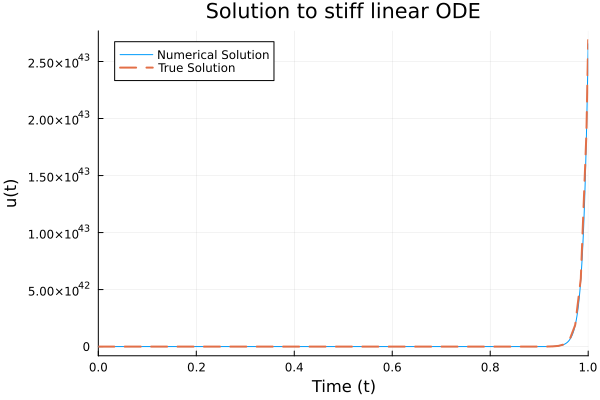

In [11]:
#Plot the numerical and true solution over the domain
plot(sol2,title="Solution to stiff linear ODE",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical Solution")
plot!(sol2.t, t->u0*exp(100t),lw=2,ls=:dash,label="True Solution")

That looks mostly reasonable, by visual inspection. Now compare to numerical values, especially at the end, as errors build up over steps.

In [12]:
@show abserr = abs(sol2(1.0)-exp(100.0))
relerr = abserr/exp(100.0)

abserr = abs(sol2(1.0) - exp(100.0)) = 3.3287791721576583e41


0.01238331142782223

That's so-so performance: we are a bit over 1 percent off. Now let's see if an implicit method can do better, either in speed or accuracy. In `DifferentialEquations.jl`, you can declare a solver explicitly, out of a huge number of options: see [the tutorial](https://docs.sciml.ai/SciMLTutorialsOutput/html/introduction/02-choosing_algs.html) for discussion. You can also let it choose one for you, by just informing it to use a method for stiff ODEs.

In [13]:
#Tell solver to use implicit algorithm
stiffsol=solve(stiffprob,alg_hints=[:stiff])

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 222-element Vector{Float64}:
 0.0
 0.005624818578328796
 0.007829910864135425
 0.011902956139696327
 0.015180319572377483
 0.019155744502194857
 0.02313116943201223
 0.027280743929416235
 0.03147867926028685
 0.035765655050296954
 0.040097668476297865
 0.04448020389499145
 0.048895592189224756
 ⋮
 0.9507353883985329
 0.95529290515891
 0.959850421919287
 0.9644079386796641
 0.9689654554400412
 0.9735229723211513
 0.9780804892022613
 0.9826380060833714
 0.9871955229644814
 0.9917530398455915
 0.9963105567267015
 1.0
u: 222-element Vector{Float64}:
   1.0
   1.7549569421610938
   2.1879240734698717
   3.2879031273920227
   4.5630156344186465
   6.790464803349249
  10.10524967255759
  15.302314209231243
  23.284517952158645
  35.74735744608761
  55.12852426270095
  85.44815055031042
 132.87876107159664
   ⋮
   1.944073179391279e41
   3.0664595028684215e41
   4.836841525327741e41
   7.6293314547228

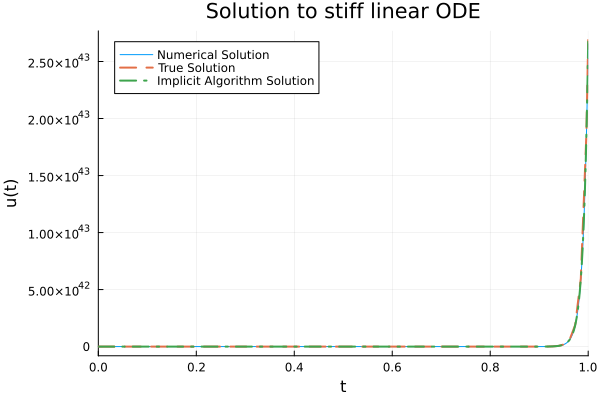

In [14]:
#Plot results, on same plot
plot!(stiffsol,lw=2,ls=:dashdot,label="Implicit Algorithm Solution")

In [15]:
#Measure results at the end
@show abserr2 = abs(stiffsol(1.0)-exp(100.0))
relerr2 = abserr2/exp(100.0)

abserr2 = abs(stiffsol(1.0) - exp(100.0)) = 7.792972585931917e40


0.002899045009871429

That gave us about an order of magnitude relative accuracy improvement, though with many more function evaluations, which may have been more expensive due to the implicit solvers. Careful, problem-specific benchmarking would be needed to know which is the more desirable method for your application.

## 빛이 나는 Solow

One of the most basic models in economics with representation as an initial value problem is the classic Solow Growth Model, which describes the process of capital accumulation and growth for a country with fixed savings rate $s$, decreasing returns to scale technology $f(k)=Ak^{\alpha}$, and initial capital $k_0$ and depreciation rate $\delta$.  In this simple model, the capital stock of the country can be defined by the ODE
$$\dot{k}=s\cdot (Ak^{\alpha}-\delta k)$$
$$k(0)=k_0$$
Let's set this up as a parameterized function and solve.

In [16]:
function solow(u,p,t)
    A,α,δ,s = p
    return s*(A*u.^α .- δ*u)
end

solow (generic function with 1 method)

In [17]:
#Set some typical parameter values
A = 1.0   #A normalization
α = 1.0/3 #Nicolas Kaldor presented empirical evidence that this is a constant, though more recent work disputes that
δ = 0.03  #Substantial disputes exist about this number 
# See http://www.econ.yale.edu//smith/piketty1.pdf for discussion of its implications, from one side of an acrimonious debate
# One sentence summary: if δ=0, accumulation is unbounded, if δ>0, it stops eventually. 
# Piketty (2014) (implicitly) used the δ=0 model, and later argued it is very small. 
# Krusell and Smith in their working paper version suggested δ≈0.05, for which they were called dishonest idiots by Brad DeLong...
s = 0.08 # This fluctuates: see https://fred.stlouisfed.org/series/PSAVERT for US data
# For countries like China (and, during their fast growth periods, Korea and Japan), this number is a lot higher 

p = (A, α, δ, s) #Collect parameters

# Initial values
k0 = 20.0 #Start with a low wealth country
tspan = (0.0,2000.0)

(0.0, 2000.0)

In [18]:
SolowProblem=ODEProblem(solow,k0,tspan,p)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 2000.0)
u0: 20.0

In [19]:
growthpath = solve(SolowProblem)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 12-element Vector{Float64}:
    0.0
    0.2597491833815667
    2.8572410171972336
   28.8321593553539
  107.38371906065225
  246.04979009414896
  424.95935324565954
  727.6475747614156
 1028.7214558522892
 1403.7897284244395
 1826.115845309841
 2000.0
u: 12-element Vector{Float64}:
  20.0
  20.043944407924858
  20.484141542271253
  24.950850790336236
  38.83089985357696
  62.910729014555045
  90.6396182970931
 126.71375943752547
 150.76100626414146
 169.15303996493287
 180.47138055946738
 183.35696457645065

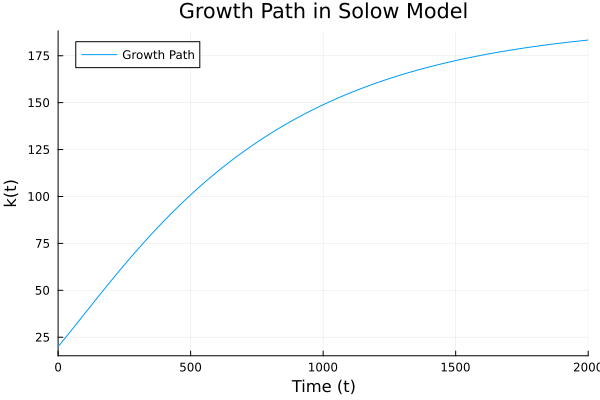

In [20]:
plot(growthpath,title="Growth Path in Solow Model",
     xaxis="Time (t)",yaxis="k(t)",label="Growth Path")

We can see why depreciation matters by noting that capital accumulation stops, $\dot{k}=0$ whenever $Ak^{\alpha}-\delta k =0$.

In [21]:
kstar = (A/δ)^(1/(1-α)) #Point at which growth no longer occurs

192.45008972987512

Note that it is not a function of $s$. However, s can make the path of getting to steady state faster.

In [22]:
s2 =0.4 #High growth country rate
p2 = (A, α, δ, s2) #Collect parameters

fastgrower = ODEProblem(solow,k0,tspan,p2)
newgrowthpath = solve(fastgrower)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 19-element Vector{Float64}:
    0.0
    0.188260925771848
    2.070870183490328
   12.43059600614991
   39.298092579973535
   72.10872710114484
  124.08859759767782
  188.35242164599168
  257.6136046227662
  341.5341961363768
  436.78517939177374
  549.0548730312703
  679.4561039238077
  834.481321842914
 1020.28677828729
 1248.9913741610314
 1537.8776296217766
 1916.1612437530312
 2000.0
u: 19-element Vector{Float64}:
  20.0
  20.159315811424253
  21.761952105067486
  30.80072497651473
  54.487715087344014
  81.18883878652231
 115.46067141422803
 144.83361059090942
 164.53824522295128
 178.00451451853183
 185.66078128148678
 189.6741983746859
 191.46976012951302
 192.1653747208647
 192.38478647516143
 192.43878208288427
 192.44828428716136
 192.4493433567827
 192.44970806405055

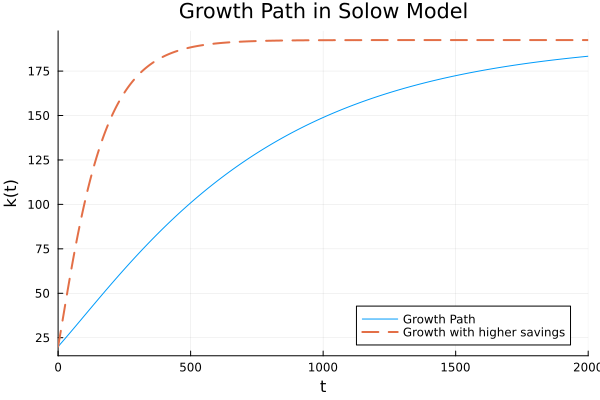

In [23]:
#Add it to the plot
plot!(newgrowthpath,lw=2,ls=:dash,label="Growth with higher savings")

This logic, showing the country with the higher savings rate reaches its steady state much earlier, has been used to argue that higher growth rates in East Asia in the late 20th century may be partially explained by their higher savings.

## Yes, SIR

To illustrate mulitvariate differential equations, we can try the classic epidemiological model of Kermack and McKendrick (1927), the SIR model, standing for the three groups in relation to a disease, the Susceptible, the Infected, and the Recovered.  This model has formulas
$$\dot{S} = -\beta SI$$
$$\dot{I} = \beta SI-\nu I$$
$$\dot{R} = \nu I$$

See <https://github.com/eehh-stanford/gceid> for discussion.

In [24]:
function SIR!(du,u,p,t) #Note in place format, with derivatives as input, and array for solution
    β, ν = p
    du[1] = -β*u[1]*u[2]
    du[2] = β*u[1]*u[2]-ν*u[2]
    du[3] = ν*u[2]
end

SIR! (generic function with 1 method)

In [25]:
#Set parameters: not necessarily realistic
β = 1.0 #Contact rate
ν = 1/3 #Speed of recovery

p = (β,ν)

u0 = [0.99,0.01,0.0]; #Start at 1% of population infected

In [26]:
tspan = (0.0,30.0)
SIRprob = ODEProblem(SIR!,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 30.0)
u0: 3-element Vector{Float64}:
 0.99
 0.01
 0.0

In [27]:
SIRpath = solve(SIRprob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 20-element Vector{Float64}:
  0.0
  0.08745103091098928
  0.3719445030714915
  0.8124354736966661
  1.3535082723949228
  2.0464277241385513
  2.8798915713150013
  3.8874782608501306
  5.092168665463747
  6.5239100837711215
  8.073797016133605
  9.793328138208732
 11.948363789387717
 13.948310855657882
 16.64696705229079
 19.379912619902314
 22.16580998033081
 25.042453902226033
 27.990967696320972
 30.0
u: 20-element Vector{Vector{Float64}}:
 [0.99, 0.01, 0.0]
 [0.9891093057268222, 0.010590662223159228, 0.0003000320500185076]
 [0.9858389504445888, 0.012757070180305384, 0.0014039793751057844]
 [0.9794447689559518, 0.01698219965565746, 0.003573031388390725]
 [0.9687406908291253, 0.024023318880360685, 0.007235990290513966]
 [0.9487371706203948, 0.03707178711014009, 0.014191042269465054]
 [0.9113904458341212, 0.0610317265882415, 0.027577827577637173]
 [0

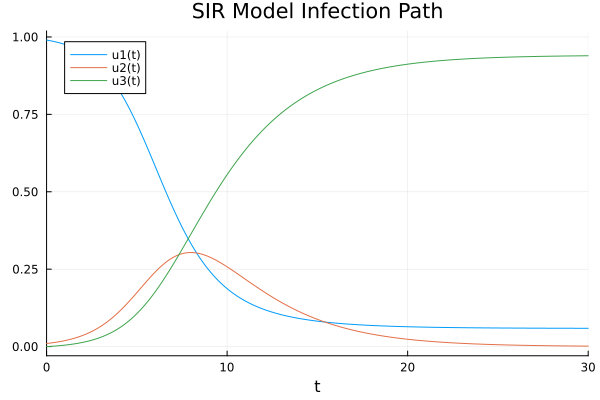

In [28]:
plot(SIRpath,title="SIR Model Infection Path")

In [29]:
#Flatten the curve
βr = 0.6 #Reduce the contact rate

p2 = (βr, ν)
SIRprob2 = ODEProblem(SIR!,u0,tspan,p2)
SIRpath2 = solve(SIRprob2)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 14-element Vector{Float64}:
  0.0
  0.08768338364980166
  0.5771567822665626
  1.5075480029136656
  2.7719378449778636
  4.410206079686798
  6.4910802358017206
  9.076831191081771
 12.106042519047
 15.600894171177051
 19.257355036301917
 23.923593964841434
 28.06253410830858
 30.0
u: 14-element Vector{Vector{Float64}}:
 [0.99, 0.01, 0.0]
 [0.9894733054937103, 0.01023105216027469, 0.00029564234601506413]
 [0.986308057245637, 0.011616272733061782, 0.0020756700213012623]
 [0.979108981316261, 0.014745469955200303, 0.006145548728538749]
 [0.9662974217743572, 0.02023965299059083, 0.013462925235051994]
 [0.9429889227094806, 0.029983077218252895, 0.02702800007226645]
 [0.8990624188651284, 0.04740845028955402, 0.05352913084531755]
 [0.8175191534361825, 0.07613054878512988, 0.10635029777868747]
 [0.6896047182969056, 0.10951420012231372, 0.20088108158078055]
 [

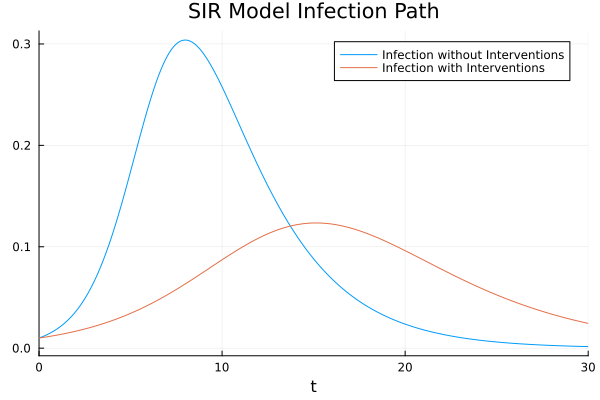

In [30]:
plot(SIRpath,idxs=(0,2),label="Infection without Interventions",title="SIR Model Infection Path")
plot!(SIRpath2,idxs=(0,2),label="Infection with Interventions")